<a href="https://colab.research.google.com/github/AkuOO4/Malayalam-News-Bias_Detection/blob/main/MODEL_FINETUNING/News_bias_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets
!pip install --upgrade transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers.trainer_callback import TrainerCallback # Explicitly import TrainerCallback
from datasets import load_dataset
import torch
from sklearn.metrics import accuracy_score

In [ ]:


# === 1. Constants ===
MODEL_NAME = "google/muril-base-cased"
NUM_LABELS = 3
LABEL2ID = {"neutral": 0, "left": 1, "right": 2}
ID2LABEL = {v: k for k, v in LABEL2ID.items()}

# === 2. Model and Tokenizer ===
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,
    id2label=ID2LABEL,
    label2id=LABEL2ID
)


tokenizer_config.json:   0%|          | 0.00/206 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/3.16M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/113 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/953M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/953M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
!ls

sample_data  train.csv	val.csv


In [ ]:
# === 3. Load Dataset ===
dataset = load_dataset(
    "csv",
    data_files={
        "train": "train.csv",
        "validation": "val.csv"
    }
)

# === 4. Tokenization ===
def tokenize_fn(example):
    return tokenizer(
        example["text"],
        truncation=True,
        padding="max_length",
        max_length=256
    )


tokenized_dataset = dataset.map(tokenize_fn, batched=True)

# Rename label to labels and make sure it is of correct type
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# Ensure labels are of type long (needed for PyTorch)
def convert_labels_to_long(example):
    # Convert string labels to numerical IDs using LABEL2ID
    example['labels'] = LABEL2ID.get(example['labels'])
    # Now convert to tensor
    example['labels'] = torch.tensor(example['labels'], dtype=torch.long)
    return example

tokenized_dataset = tokenized_dataset.map(convert_labels_to_long)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/1501 [00:00<?, ? examples/s]

Map:   0%|          | 0/376 [00:00<?, ? examples/s]

Map:   0%|          | 0/1501 [00:00<?, ? examples/s]

Map:   0%|          | 0/376 [00:00<?, ? examples/s]

In [ ]:

# === 5. Custom Callback for Saving Every 2 Epochs ===
class SaveEveryNEpochsCallback(TrainerCallback):
    def __init__(self, save_every_n_epochs, tokenizer): # Pass tokenizer during initialization
        self.save_every_n_epochs = save_every_n_epochs
        self.tokenizer = tokenizer  # Store tokenizer as an instance variable

    def on_epoch_end(self, args, state, control, **kwargs): # Remove model, tokenizer from arguments
        epoch = int(state.epoch)
        if epoch % self.save_every_n_epochs == 0:
            checkpoint_dir = f"{args.output_dir}/checkpoint-epoch-{epoch}"
            kwargs.get("model").save_pretrained(checkpoint_dir)  # Access model from kwargs
            self.tokenizer.save_pretrained(checkpoint_dir) # Use instance variable tokenizer
            print(f"✅ Saved checkpoint at {checkpoint_dir}")
        return control

# === 6. Metrics ===
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = torch.argmax(torch.tensor(logits), dim=-1)

    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')

    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }
from torch.utils.data import DataLoader, WeightedRandomSampler

# Here, we rename the labels and set the format
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# === 2. Calculate Class Weights (for handling imbalance) ===
# Get the counts of each label
label_counts = [622, 196, 683]  # Example counts for 'left', 'neutral', 'right'
class_weights = torch.tensor([1.0 / count for count in label_counts], dtype=torch.float)

# === 3. Assign Weights to Each Sample ===
weights = [class_weights[label] for label in tokenized_dataset["train"]["labels"]]

# === 4. Create Weighted Sampler ===
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

# === 5. Create DataLoader with Sampler ===
train_dataloader = DataLoader(
    tokenized_dataset["train"],
    sampler=sampler,
    batch_size=16  # Adjust batch size as needed
)
from transformers import TrainingArguments, Trainer


# If you still get errors, try this minimal version:
training_args = TrainingArguments(
    output_dir="malayalam-classifier",
    num_train_epochs=12,
    per_device_train_batch_size=36,
    per_device_eval_batch_size=16,
    # Basic evaluation
    eval_steps=500,  # Evaluate every 500 steps
    save_steps=500,  # Save every 500 steps
    logging_steps=50,
    learning_rate=3e-5,
    weight_decay=0.01,
)

# === 7. Trainer Setup ===
# === 5. Initialize Trainer with Callback ===
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    compute_metrics=compute_metrics,
    callbacks=[SaveEveryNEpochsCallback(save_every_n_epochs=2, tokenizer=tokenizer)]  # Pass tokenizer here
)
# === 8. Train the Model ===



In [ ]:
# === 9. Train ===
trainer.train()


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: akshayks2004 (akshayks2004-school-of-engineering-cusat) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
50,1.065000
100,0.955200
150,0.824700
200,0.672000
250,0.548600
300,0.472200
350,0.406200
400,0.348600
450,0.305600


✅ Saved checkpoint at malayalam-classifier/checkpoint-epoch-2
✅ Saved checkpoint at malayalam-classifier/checkpoint-epoch-4
✅ Saved checkpoint at malayalam-classifier/checkpoint-epoch-6
✅ Saved checkpoint at malayalam-classifier/checkpoint-epoch-8
✅ Saved checkpoint at malayalam-classifier/checkpoint-epoch-10


Step,Training Loss
50,1.065000
100,0.955200
150,0.824700
200,0.672000
250,0.548600
300,0.472200
350,0.406200
400,0.348600
450,0.305600
500,0.286300


✅ Saved checkpoint at malayalam-classifier/checkpoint-epoch-12


TrainOutput(global_step=504, training_loss=0.5863411263340995, metrics={'train_runtime': 1033.9866, 'train_samples_per_second': 17.42, 'train_steps_per_second': 0.487, 'total_flos': 2369599440058368.0, 'train_loss': 0.5863411263340995, 'epoch': 12.0})

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


# Evaluate
results = trainer.evaluate()

# Print metrics
print("Validation Accuracy:", results["eval_accuracy"])
print("Validation F1 Score:", results["eval_f1"])
print("Validation Precision:", results["eval_precision"])
print("Validation Recall:", results["eval_recall"])


Validation Accuracy: 0.925531914893617
Validation F1 Score: 0.9251431944302635
Validation Precision: 0.9278467355335506
Validation Recall: 0.925531914893617


In [ ]:
# prompt: read two test sentence stored as txt file

def read_sentences(filepath):
  """Reads two sentences from a text file.

  Args:
    filepath: Path to the text file.

  Returns:
    A tuple containing the two sentences, or None if the file
    doesn't contain two lines.
  """

  with open(filepath, 'r') as file:
    sentences = [line.strip() for line in file]
    return sentences

# Example usage
right = read_sentences("/content/right.txt")  # Replace "your_file.txt"

left = read_sentences("/content/right.txt")
test_sentences = [right,left]

In [ ]:
# Example sentences for prediction

inputs = tokenizer(test_sentences, padding=True, truncation=True, return_tensors="pt", max_length=256)

# Move inputs to the same device as the model
inputs = inputs.to(model.device) # Move inputs to the model's device

# Get model predictions
model.eval()  # Switch model to evaluation mode
with torch.no_grad():  # Disable gradient calculation for inference
    outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=-1)  # Get probabilities

# Check the logits and probabilities
for sentence, prob in zip(test_sentences, probabilities):
    print(f"=> Predicted Probabilities: {prob}")

=> Predicted Probabilities: tensor([0.0013, 0.0012, 0.9976], device='cuda:0')
=> Predicted Probabilities: tensor([0.0013, 0.0012, 0.9976], device='cuda:0')


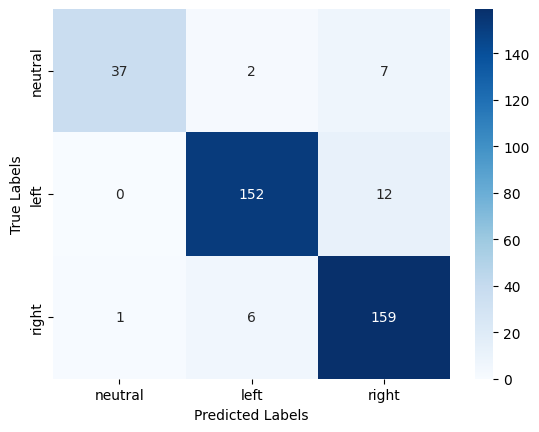

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get model predictions
predictions = trainer.predict(tokenized_dataset["validation"])

logits = predictions.predictions
predicted_labels = torch.argmax(torch.tensor(logits), dim=-1)

# Calculate confusion matrix
cm = confusion_matrix(tokenized_dataset["validation"]["labels"], predicted_labels)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["neutral", "left", "right"], yticklabels=["neutral", "left", "right"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [ ]:
# Saving the trained model to the output directory
model.save_pretrained("malayalam-classifier")
tokenizer.save_pretrained("malayalam-classifier")


('malayalam-classifier/tokenizer_config.json',
 'malayalam-classifier/special_tokens_map.json',
 'malayalam-classifier/vocab.txt',
 'malayalam-classifier/added_tokens.json',
 'malayalam-classifier/tokenizer.json')

In [ ]:
import shutil

# Create a zip file containing the model and tokenizer
shutil.make_archive("malayalam-classifier", 'zip', "malayalam-classifier")

# After this, you can download the zip file
from google.colab import files
files.download("malayalam-classifier.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os
import shutil

# Define your model directory
model_dir = "malayalam-classifier"

# Step 1: Delete unwanted files
unwanted_files = [
    "trainer_state.json",
    "training_args.bin",
]

for filename in unwanted_files:
    file_path = os.path.join(model_dir, filename)
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"Deleted {filename}")

# Step 2: Delete all checkpoint folders
for subdir in os.listdir(model_dir):
    if subdir.startswith("checkpoint"):
        checkpoint_path = os.path.join(model_dir, subdir)
        shutil.rmtree(checkpoint_path)
        print(f"Deleted checkpoint folder: {subdir}")

print("✅ Model directory cleaned and ready for download!")


Deleted checkpoint folder: checkpoint-epoch-4
Deleted checkpoint folder: checkpoint-epoch-12
Deleted checkpoint folder: checkpoint-504
Deleted checkpoint folder: checkpoint-epoch-6
Deleted checkpoint folder: checkpoint-500
Deleted checkpoint folder: checkpoint-epoch-10
Deleted checkpoint folder: checkpoint-epoch-8
Deleted checkpoint folder: checkpoint-epoch-2
✅ Model directory cleaned and ready for download!


In [ ]:
import os

model_path = "malayalam-classifier/model.safetensors"
size_mb = os.path.getsize(model_path) / (1024 * 1024)  # Convert bytes to MB

print(f"Model file size: {size_mb:.2f} MB")


FileNotFoundError: [Errno 2] No such file or directory: 'malayalam-classifier/model.safetensors'

In [ ]:
# Assuming you have already loaded your model
# For example: model = AutoModelForSequenceClassification.from_pretrained('malayalam-classifier')

def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

count_parameters(model)


Total parameters: 237,558,531
Trainable parameters: 237,558,531


In [ ]:
import shutil

# Zip the "malayalam-classifier" directory
shutil.make_archive("malayalam-classifier", 'zip', "malayalam-classifier")


'/content/malayalam-classifier.zip'

In [ ]:
from google.colab import files

# Download the zipped model
files.download("malayalam-classifier.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>